In [ ]:
# !pip install transformers

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchtext.functional as F

import pandas as pd

import transformers
from transformers import AutoModel, BertTokenizerFast

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# specify device
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/usr/shared/CMPT/big-data/condaenv/gt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [15]:
data = pd.read_csv('data.csv')

# See how the data looks like
print(data.shape)
data.head()

(19398, 2)


,label,text
0,1,Says the Annies List political group supports ...
1,0,When did the decline of coal start? It started...
2,0,"Hillary Clinton agrees with John McCain ""by vo..."
3,1,Health care reform legislation is likely to ma...
4,0,The economic turnaround started at the end of ...


## Split Train and Test Set

In [16]:
# train: test: val = 70:15:15
train_text, val_test_text, train_labels, val_test_labels = train_test_split(data['text'], data['label'], test_size=0.3, stratify=data['label'])
val_text, test_text, val_labels, test_labels = train_test_split(val_test_text, val_test_labels, test_size=0.5, stratify=val_test_labels)

## Prepare Input Data

### Tokenizer

In [17]:
# Load BERT model and tokenizer via HuggingFace Transformers
do_use_bert_large = False
if do_use_bert_large:
    bert = AutoModel.from_pretrained('bert-large-uncased')
    tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased')    
else:
    bert = AutoModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text(0, 0.5, 'Number of texts')

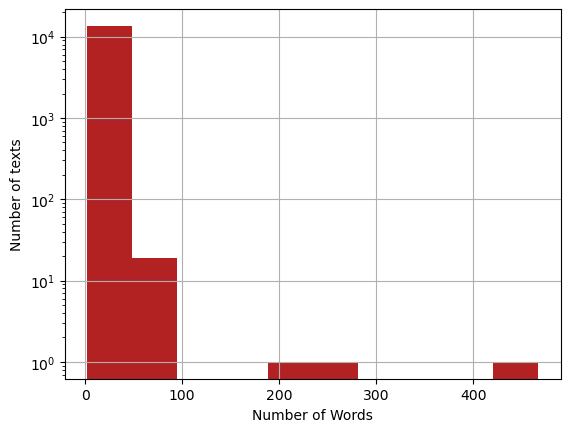

In [5]:
# Plot histogram of the number of words in training set
seq_len = [len(text.split()) for text in train_text]

pd.Series(seq_len).hist(log = True)
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:
MAX_LENGHT = 65

# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    padding="max_length", 
    max_length=MAX_LENGHT,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    padding="max_length", 
    max_length=MAX_LENGHT,
    truncation=True
)
# tokenize and encode sequences in the testing set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    padding="max_length", 
    max_length=MAX_LENGHT,
    truncation=True
)

In [19]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

### Data Loader

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
BATCH_SIZE = 64

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(val_seq, val_mask, val_y)     
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=BATCH_SIZE)

## Prepare BERT Model

### Freeze Layers

In [21]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False

### Model Architecture

In [34]:
# Define hyperparameters
EPOCHS = 8
USE_GPU = torch.cuda.is_available()
DROPOUT = .1
LEARNING_RATE = 2e-5

In [25]:
class BERT_CLF(nn.Module):
    def __init__(self, bert):  
        super(BERT_CLF, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(DROPOUT)          # dropout layer
        self.relu =  nn.ReLU()                      # relu activation function
        if do_use_bert_large:
            self.fc1 = nn.Linear(1024,512)          # fully connected layer 1
            self.fc2 = nn.Linear(512,2)             # Output layer
        else:
            self.fc1 = nn.Linear(768,512)           # fully connected layer 1
            self.fc2 = nn.Linear(512,2)             # output layer
        self.softmax = nn.LogSoftmax(dim=1)         # softmax activation function

    def forward(self, sent_id, mask):
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)                           # output
        x = self.softmax(x)                       # softmax
        return x

model = BERT_CLF(bert)

### Training Methods

In [35]:
import lightning.pytorch as pl

from torch.optim import AdamW

class LitModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.train()
        self.criteria = nn.CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
        sent_id, mask, labels = batch
        output = self.model(sent_id, mask)
        loss = self.criteria(output, labels)
        
        # compute step accuracy
        correct_predictions = (output.argmax(1) == labels).sum().item()
        total_predictions = len(labels)
        acc = correct_predictions / total_predictions
        
        # pass performance info to logger
        self.log("train_loss", loss, on_step = False, on_epoch=True, batch_size=BATCH_SIZE, logger=True)
        self.log('train_accuracy', acc, on_step = False, on_epoch=True, batch_size=BATCH_SIZE, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        sent_id, mask, labels = batch
        output = self.model(sent_id, mask)
        loss = self.criteria(output, labels)
        
        # compute step accuracy
        correct_predictions = (output.argmax(1) == labels).sum().item()
        total_predictions = len(labels)
        acc = correct_predictions / total_predictions
        
        # pass performance info to logger
        self.log("val_loss", loss, on_step = False, on_epoch=True, batch_size=BATCH_SIZE, logger=True)
        self.log('val_accuracy', acc, on_step = False, on_epoch=True, batch_size=BATCH_SIZE, logger=True)

        return loss

    def configure_optimizers(self):
        return AdamW(self.model.parameters(), lr=LEARNING_RATE)

In [36]:
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

tb_logdir = "logs-proj"

logger = TensorBoardLogger(tb_logdir, name="BERT_model")
trainer = Trainer(logger=logger, max_epochs=EPOCHS)
torch.cuda.empty_cache()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [37]:
trainer.fit(LitModel(model), train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | model    | BERT_Arch        | 109 M 
1 | criteria | CrossEntropyLoss | 0     
----------------------------------------------
394 K     Trainable params
109 M     Non-trainable params
109 M     Total params
439.508   Total estimated model params size (MB)


Epoch 0: 100%|██████████████████████| 425/425 [00:36<00:00, 11.78it/s, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████████████████| 425/425 [00:36<00:00, 11.68it/s, v_num=16]
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                        | 0/91 [00:00<?, ?it/s]


Epoch 2: 100%|██████████████████████| 425/425 [00:36<00:00, 11.65it/s, v_num=16]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   2%|▍                  | 2/91 [00:00<00:07, 12.08it/s]


Epoch 3: 100%|██████████████████████| 425/425 [00:36<00:00, 11.65it/s, v_num=16]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   5%|█                  | 5/91 [00:00<00:07, 12.06it/s]


Epoch 4: 100%|██████████████████████| 425/425 [00:36<00:00, 11.67it/s, v_num=16]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   9%|█▋                 | 8/91 [00:00<00:06, 12.07it/s]


Epoch 5: 100%|██████████████████████| 425/425 [00:36<00:00, 11.70it/s, v_num=16]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|██▏               | 11/91 [00:00<00:06, 12.05it/s]


Epoch 6: 100%|██████████████████████| 425/425 [00:36<00:00, 11.66it/s, v_num=16]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  15%|██▊               | 14/91 [00:01<00:06, 12.07it/s]


Epoch 7: 100%|██████████████████████| 425/425 [00:36<00:00, 11.67it/s, v_num=16]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  19%|███▎              | 17/91 [00:01<00:06, 12.02it/s]


Epoch 8: 100%|██████████████████████| 425/425 [00:36<00:00, 11.66it/s, v_num=16]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  22%|███▉              | 20/91 [00:01<00:05, 12.01it/s]


Epoch 9: 100%|██████████████████████| 425/425 [00:36<00:00, 11.65it/s, v_num=16]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  25%|████▌             | 23/91 [00:01<00:05, 12.09it/s]


Epoch 10: 100%|█████████████████████| 425/425 [00:36<00:00, 11.65it/s, v_num=16]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  29%|█████▏            | 26/91 [00:02<00:05, 12.10it/s]


Epoch 11: 100%|█████████████████████| 425/425 [00:36<00:00, 11.66it/s, v_num=16]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  32%|█████▋            | 29/91 [00:02<00:05, 12.08it/s]


Epoch 11: 100%|█████████████████████| 425/425 [00:43<00:00,  9.66it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=12` reached.


Epoch 11: 100%|█████████████████████| 425/425 [00:48<00:00,  8.73it/s, v_num=16]


In [ ]:
torch.save(model.state_dict(), "BERT_based.pt")